## Clustering Neighborhoods in Toronto Project

### 1. Scrape data from wiki page

In [1]:
# import libraries
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [3]:
wiki_cont = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").content
soup = BeautifulSoup(wiki_cont, 'html.parser')

In [4]:
table = soup.find('tbody')
rows = table.select('tr')
row = [r.get_text() for r in rows]

In [5]:
# get rid of empty element 
row2 = [list(filter(None,x.split('\n'))) for x in row if x.split('\n')]
df = pd.DataFrame(row2 )
df.columns = df.iloc[0]
df2 = df.iloc[1:,:]
df2.head(5)

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


### 2. Data cleaning and manipulation

In [6]:
# Ignore cells with a borough that is Not assigned
df3 = df2[df2['Borough'] != 'Not assigned']
# combine neightborhoods in same post code
df4 = df3.groupby(['Postcode', 'Borough']).agg(','.join).reset_index()

In [7]:
df4.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
# check how many records have 'not assigned' neighbourhood
df4[df4.Neighbourhood == 'Not assigned']

,Postcode,Borough,Neighbourhood
85,M7A,Queen's Park,Not assigned


In [9]:
# replace 'Not assigned' neighbourhood to Queen's Park
df4['Neighbourhood'] = df4['Neighbourhood'].replace("Not assigned", "Queen's Park")

In [10]:
df4.shape

(103, 3)

## Include latitude and longtitude coordinate of each neighborhood (using csv files)

In [11]:
url = "http://cocl.us/Geospatial_data"
added_df = pd.read_csv(url)
added_df.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
added_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
# merge coordinate data into previous data
df5 = pd.merge(df4, added_df, on = 'Postcode', how = 'inner')
df5.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## clustering Toronto Neighborhoods

In [13]:
target_df = df5[df5.Borough.str.contains('Toronto')]
print('there are {} neighborhoods in Toronto'.format(target_df.shape[0]))
target_df.head()

there are 38 neighborhoods in Toronto


,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [84]:
target_df.shape

(38, 5)

In [85]:
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [86]:
address = 'Toronto'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(target_df['Latitude'], target_df['Longitude'], 
                                           target_df['Borough'], target_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map

In [87]:
CLIENT_ID = 'OU4RIIISYQ4ZXDPUOFWDITBL4SUW0Y3SP2U1TQF1UZD4B44H' # Foursquare ID
CLIENT_SECRET = 'AXL4HV5WL1N3CNBSRFP3TCVT5PAJL5YKPM2IEGBIHZ245G4T' # Foursquare Secret
VERSION = '20180605' # API version
LIMIT = 100

In [88]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [89]:
target_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [90]:
venues = getNearbyVenues(names=target_df['Neighbourhood'],latitudes=target_df['Latitude'],longitudes=target_df['Longitude'])

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvall

In [91]:
print(venues.shape)
venues.head()

(1697, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [92]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Brockton,Exhibition Place,Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",16,16,16,16,16,16
"Cabbagetown,St. James Town",43,43,43,43,43,43
Central Bay Street,88,88,88,88,88,88
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


In [93]:
# one-hot encoding to transform all variables in category field into numeric features for clustering
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

onehot.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2                Café  0.04
3              Bakery  0.04
4  Seafood Restaurant  0.04


----Brockton,Exhibition Place,Parkdale Village----
            venue  freq
0  Breakfast Spot  0.10
1            Café  0.10
2     Coffee Shop  0.10
3   Burrito Place  0.05
4   Grocery Store  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1         Yoga Studio  0.05
2       Auto Workshop  0.05
3             Brewery  0.05
4         Pizza Place  0.05


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
                venue  freq
0     Airport Service  0.19
1      Airpor

In [95]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Thai Restaurant,Asian Restaurant,Hotel,Cosmetics Shop,Bakery
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse,Seafood Restaurant,Farmers Market,Café,Beer Bar,Park
2,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym,Intersection,Performing Arts Venue,Pet Store,Office,Climbing Gym,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Coffee Shop,Sculpture Garden,Boat or Ferry,Boutique,Airport Food Court
5,"Cabbagetown,St. James Town",Coffee Shop,Restaurant,Café,Italian Restaurant,Bakery,Pub,Pizza Place,Pet Store,Sandwich Place,Butcher
6,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Japanese Restaurant,Bubble Tea Shop
7,"Chinatown,Grange Park,Kensington Market",Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bar,Bakery,Dumpling Restaurant,Mexican Restaurant,Chinese Restaurant,Coffee Shop,Caribbean Restaurant
8,Christie,Grocery Store,Café,Park,Italian Restaurant,Coffee Shop,Baby Store,Restaurant,Nightclub,Diner,Convenience Store
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Gym,Mediterranean Restaurant,Bubble Tea Shop,Gastropub,Fast Food Restaurant


## Clustering Neighborhoods

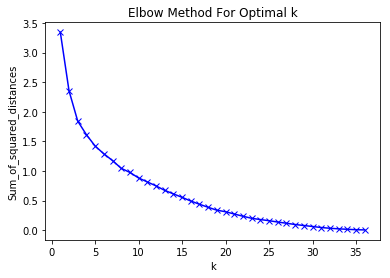

In [97]:
# Selecting best k to cluster base on within-cluster sum of square distance, also known as elbow method

import matplotlib.pyplot as plt
# drop neighborhood column
grouped_clustering = grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = np.arange(1,37)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [98]:
# set number of clusters, 4 or 5 will be a good choice based on our analysis
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
merged = grouped

# add clustering labels
merged['Cluster Labels'] = kmeans.labels_
merged2 = merged.iloc[:,[0,-1]]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
result = merged2.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

result.head() # check the last columns!

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",0,Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Thai Restaurant,Asian Restaurant,Hotel,Cosmetics Shop,Bakery
1,Berczy Park,0,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse,Seafood Restaurant,Farmers Market,Café,Beer Bar,Park
2,"Brockton,Exhibition Place,Parkdale Village",0,Coffee Shop,Café,Breakfast Spot,Gym,Intersection,Performing Arts Venue,Pet Store,Office,Climbing Gym,Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,0,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0,Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Coffee Shop,Sculpture Garden,Boat or Ferry,Boutique,Airport Food Court


In [103]:
result2 = pd.merge(target_df, result, left_on= 'Neighbourhood', right_on = 'Neighborhood', how = 'right' )

In [104]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result2['Latitude'], result2['Longitude'], result2['Neighborhood'], result2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## There are 37 neightborhoods in Tornado, we obtain four groups after implementing Kmeans Clustering. However, one cluster dominates all the rest cluster in this case. 